<a href="https://colab.research.google.com/github/zhe0/prac/blob/main/multimodal_tabular_withImportance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Sat Feb 10 07:48:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
# !pip -qqq install pip --upgrade
# !pip -qqq install torch==2.0.1+cu117 --extra-index-url https://download.pytorch.org/whl/nightly/cu117
# !pip -qqq install autogluon.multimodal
# !pip -qqq install autogluon.tabular[all]
# !pip -qqq install typing_extensions==4.8.0 --force-reinstall
# !pip install -qqq accelerate

ERROR: Could not find a version that satisfies the requirement torch==2.0.1+cu117 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0.dev20230621+cu117, 2.1.0, 2.1.1, 2.1.2, 2.2.0)
ERROR: No matching distribution found for torch==2.0.1+cu117


In [4]:
!pip uninstall torchaudio -y

Found existing installation: torchaudio 2.1.0+cu121
Uninstalling torchaudio-2.1.0+cu121:
  Successfully uninstalled torchaudio-2.1.0+cu121


In [5]:
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

## Dataset

For demonstration, we use a simplified and subsampled version of [PetFinder dataset](https://www.kaggle.com/c/petfinder-adoption-prediction). The task is to predict the animals' adoption rates based on their adoption profile information. In this simplified version, the adoption speed is grouped into two categories: 0 (slow) and 1 (fast).

To get started, let's download and prepare the dataset.

In [10]:
# download_dir = './ag_automm_tutorial'
# zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'
# from autogluon.core.utils.loaders import load_zip
# load_zip.unzip(zip_file, unzip_dir=download_dir)

!gdown 16_Ql6zKjm8ugpzh-_9zsP2rKAN5BjG-c
!unzip -o /content/petfinder_for_tutorial.zip

Downloading...
From: https://drive.google.com/uc?id=16_Ql6zKjm8ugpzh-_9zsP2rKAN5BjG-c
To: /content/petfinder_for_tutorial.zip
100% 18.8M/18.8M [00:00<00:00, 171MB/s]
Archive:  /content/petfinder_for_tutorial.zip
   creating: petfinder_for_tutorial/
  inflating: petfinder_for_tutorial/test.csv  
  inflating: petfinder_for_tutorial/train.csv  
   creating: petfinder_for_tutorial/images/
  inflating: petfinder_for_tutorial/images/5ca64db1a-1.jpg  
  inflating: petfinder_for_tutorial/images/889ae00e3-1.jpg  
  inflating: petfinder_for_tutorial/images/7d7a39d71-1.jpg  
  inflating: petfinder_for_tutorial/images/cddbe627c-1.jpg  
  inflating: petfinder_for_tutorial/images/c4718084c-1.jpg  
  inflating: petfinder_for_tutorial/images/9cbc1fb81-1.jpg  
  inflating: petfinder_for_tutorial/images/7827eee65-1.jpg  
  inflating: petfinder_for_tutorial/images/172305d1b-1.jpg  
  inflating: petfinder_for_tutorial/images/79ef1fd27-1.jpg  
  inflating: petfinder_for_tutorial/images/2b2ec33ac-1.jpg  
  

Next, we will load the CSV files.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

dataset_path='/content/petfinder_for_tutorial'
data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
rm=['Name','RescuerID','PetID']
data=data[[i for i in data.columns if not i in rm]]

train_data,test_data=train_test_split(data,test_size=0.1)
print(len(train_data),len(test_data))
train_data.head()

label_col = 'AdoptionSpeed'
# 我們預計要predict AdoptionSpeed的可能值，越短越快
train_data[label_col].unique()

540 60


array([1, 0])

We need to expand the image paths to load them in training.

In [12]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

print('img path and file name: ',train_data[image_col].iloc[0])

example_row = train_data.iloc[0]
print('first row info: ',example_row)

print('PET Description: ',example_row['Description'])

img path and file name:  /content/petfinder_for_tutorial/images/87a679d31-1.jpg
first row info:  Type                                                             1
Age                                                              6
Breed1                                                         307
Breed2                                                           0
Gender                                                           1
Color1                                                           2
Color2                                                           0
Color3                                                           0
MaturitySize                                                     2
FurLength                                                        2
Vaccinated                                                       1
Dewormed                                                         2
Sterilized                                                       2
Health                          

Each animal's adoption profile includes pictures, a text description, and various tabular features such as age, breed, name, color, and more. Let's look at an example row of data and display the text description and a picture.

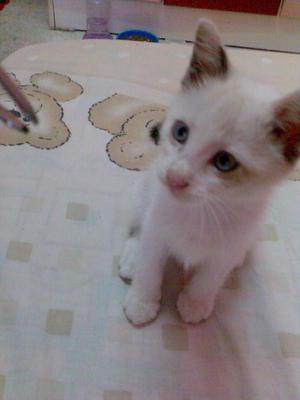

In [ ]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

## before training
* set acutual column type
* multimodal might help?

In [35]:
from autogluon.tabular import TabularPredictor
from autogluon.tabular.configs.hyperparameter_configs import get_hyperparameter_config

predictor = TabularPredictor(label=label_col, verbosity=4)

hyperparameters = get_hyperparameter_config('multimodal')
hyperparameters

No path specified. Models will be saved in: "AutogluonModels/ag-20240210_085142"


{'NN_TORCH': {},
 'GBM': [{},
  {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}},
  'GBMLarge'],
 'CAT': {},
 'XGB': {},
 'AG_AUTOMM': {},
 'VW': {}}

In [36]:
from autogluon.tabular import FeatureMetadata
# ref 指定資料形態時，可先看目前支援的type:
# https://auto.gluon.ai/0.4.0/api/autogluon.predictor.html?highlight=feature_metadata#featuremetadata

feature_metadata = FeatureMetadata.from_df(train_data)

print('automatically set col type: ',feature_metadata)
print('---'*30)
cate=['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize','State',
      'FurLength','Vaccinated','Dewormed','Sterilized','Health']
feature_metadata = feature_metadata.add_special_types({
    image_col: ['image_path'],
    'Description': ['text'],
    })
for i in cate:
  feature_metadata=feature_metadata.add_special_types({i:['category']})

print('add col special types',feature_metadata)

automatically set col type:  ('float', [])        :  1 | ['PhotoAmt']
('int', [])          : 19 | ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', ...]
('object', [])       :  1 | ['Images']
('object', ['text']) :  1 | ['Description']
------------------------------------------------------------------------------------------
add col special types ('float', [])              :  1 | ['PhotoAmt']
('int', [])                :  6 | ['Type', 'Age', 'Quantity', 'Fee', 'VideoAmt', ...]
('int', ['category'])      : 13 | ['Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', ...]
('object', ['image_path']) :  1 | ['Images']
('object', ['text'])       :  1 | ['Description']


## Training
Now let's fit the predictor with the training data. Here we set a tight time budget for a quick demo.

In [37]:
p={'train_data':train_data,
  'hyperparameters':hyperparameters,
  'feature_metadata':feature_metadata,
    'time_limit':30,}
predictor.fit(**p)

No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
============ fit kwarg info ============
User Specified kwargs:
{}
Full kwargs:
{'_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': False,
 'calibrate': 'auto',
 'ds_args': {'clean_up_fits': True,
             'detection_time_frac': 0.25,
             'holdout_data': None,
             'holdout_frac': 0.1111111111111111

[1]	valid_set's binary_error: 0.37037
[2]	valid_set's binary_error: 0.37037
[3]	valid_set's binary_error: 0.351852
[4]	valid_set's binary_error: 0.361111
[5]	valid_set's binary_error: 0.37037
[6]	valid_set's binary_error: 0.361111
[7]	valid_set's binary_error: 0.361111
[8]	valid_set's binary_error: 0.361111
[9]	valid_set's binary_error: 0.361111
[10]	valid_set's binary_error: 0.333333
[11]	valid_set's binary_error: 0.342593
[12]	valid_set's binary_error: 0.351852
[13]	valid_set's binary_error: 0.342593
[14]	valid_set's binary_error: 0.342593
[15]	valid_set's binary_error: 0.342593
[16]	valid_set's binary_error: 0.324074
[17]	valid_set's binary_error: 0.333333
[18]	valid_set's binary_error: 0.333333
[19]	valid_set's binary_error: 0.333333
[20]	valid_set's binary_error: 0.333333
[21]	valid_set's binary_error: 0.333333
[22]	valid_set's binary_error: 0.351852
[23]	valid_set's binary_error: 0.342593
[24]	valid_set's binary_error: 0.333333
[25]	valid_set's binary_error: 0.342593
[26]	valid_s

Saving AutogluonModels/ag-20240210_085142/models/LightGBM/model.pkl
Saving AutogluonModels/ag-20240210_085142/utils/attr/LightGBM/y_pred_proba_val.pkl
	0.713	 = Validation score   (accuracy)
	0.72s	 = Training   runtime
	0.01s	 = Validation runtime
Saving AutogluonModels/ag-20240210_085142/models/trainer.pkl
Fitting model: LightGBMXT ... Training model for up to 26.23s of the 26.21s of remaining time.
	Dropped 2 of 226 features.
	Fitting LightGBMXT with 'num_gpus': 0, 'num_cpus': 1
	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05, 'extra_trees': True}


[499]	valid_set's binary_error: 0.314815
[500]	valid_set's binary_error: 0.314815
[501]	valid_set's binary_error: 0.314815
[502]	valid_set's binary_error: 0.314815
[503]	valid_set's binary_error: 0.314815
[504]	valid_set's binary_error: 0.314815
[505]	valid_set's binary_error: 0.314815
[506]	valid_set's binary_error: 0.314815
[507]	valid_set's binary_error: 0.314815
[508]	valid_set's binary_error: 0.314815
[509]	valid_set's binary_error: 0.314815
[1]	valid_set's binary_error: 0.509259
[2]	valid_set's binary_error: 0.425926
[3]	valid_set's binary_error: 0.351852
[4]	valid_set's binary_error: 0.351852
[5]	valid_set's binary_error: 0.37037
[6]	valid_set's binary_error: 0.342593
[7]	valid_set's binary_error: 0.361111
[8]	valid_set's binary_error: 0.37037
[9]	valid_set's binary_error: 0.37963
[10]	valid_set's binary_error: 0.37037
[11]	valid_set's binary_error: 0.37037
[12]	valid_set's binary_error: 0.388889
[13]	valid_set's binary_error: 0.351852
[14]	valid_set's binary_error: 0.342593
[15

Saving AutogluonModels/ag-20240210_085142/models/LightGBMXT/model.pkl
Saving AutogluonModels/ag-20240210_085142/utils/attr/LightGBMXT/y_pred_proba_val.pkl
	0.7037	 = Validation score   (accuracy)
	0.58s	 = Training   runtime
	0.01s	 = Validation runtime
Saving AutogluonModels/ag-20240210_085142/models/trainer.pkl
Fitting model: CatBoost ... Training model for up to 25.62s of the 25.61s of remaining time.
	Dropped 2 of 226 features.
	Fitting CatBoost with 'num_gpus': 0, 'num_cpus': 1


[304]	valid_set's binary_error: 0.324074
[305]	valid_set's binary_error: 0.324074
[306]	valid_set's binary_error: 0.324074
[307]	valid_set's binary_error: 0.324074
[308]	valid_set's binary_error: 0.324074
[309]	valid_set's binary_error: 0.324074
[310]	valid_set's binary_error: 0.324074
[311]	valid_set's binary_error: 0.324074
[312]	valid_set's binary_error: 0.324074
[313]	valid_set's binary_error: 0.324074
[314]	valid_set's binary_error: 0.333333
[315]	valid_set's binary_error: 0.333333
[316]	valid_set's binary_error: 0.324074
[317]	valid_set's binary_error: 0.324074
[318]	valid_set's binary_error: 0.324074
[319]	valid_set's binary_error: 0.324074
[320]	valid_set's binary_error: 0.324074
[321]	valid_set's binary_error: 0.314815
[322]	valid_set's binary_error: 0.314815
[323]	valid_set's binary_error: 0.324074
[324]	valid_set's binary_error: 0.324074
[325]	valid_set's binary_error: 0.324074
[326]	valid_set's binary_error: 0.324074
[327]	valid_set's binary_error: 0.324074
[328]	valid_set'

	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy', 'thread_count': 1}


0:	learn: 0.6689815	test: 0.6018519	best: 0.6018519 (0)	total: 4.91ms	remaining: 49.1s
1:	learn: 0.6944444	test: 0.6111111	best: 0.6111111 (1)	total: 9.09ms	remaining: 45.4s
2:	learn: 0.7175926	test: 0.6759259	best: 0.6759259 (2)	total: 13.6ms	remaining: 45.4s
3:	learn: 0.7268519	test: 0.6574074	best: 0.6759259 (2)	total: 18ms	remaining: 45s
4:	learn: 0.7430556	test: 0.6666667	best: 0.6759259 (2)	total: 22.5ms	remaining: 44.9s
5:	learn: 0.7384259	test: 0.6481481	best: 0.6759259 (2)	total: 26.7ms	remaining: 44.5s
6:	learn: 0.7615741	test: 0.6481481	best: 0.6759259 (2)	total: 31.3ms	remaining: 44.6s
7:	learn: 0.7708333	test: 0.6574074	best: 0.6759259 (2)	total: 35.6ms	remaining: 44.5s
8:	learn: 0.7731481	test: 0.6296296	best: 0.6759259 (2)	total: 39.8ms	remaining: 44.2s
9:	learn: 0.8009259	test: 0.6666667	best: 0.6759259 (2)	total: 44.4ms	remaining: 44.4s
10:	learn: 0.7916667	test: 0.6388889	best: 0.6759259 (2)	total: 48.9ms	remaining: 44.4s
11:	learn: 0.7870370	test: 0.6388889	best: 0.6

Saving AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Saving AutogluonModels/ag-20240210_085142/utils/attr/CatBoost/y_pred_proba_val.pkl
	0.7315	 = Validation score   (accuracy)
	3.23s	 = Training   runtime
	0.01s	 = Validation runtime
Saving AutogluonModels/ag-20240210_085142/models/trainer.pkl
Fitting model: XGBoost ... Training model for up to 22.36s of the 22.35s of remaining time.
	Dropped 2 of 226 features.
	Fitting XGBoost with 'num_gpus': 0, 'num_cpus': 1


593:	learn: 1.0000000	test: 0.6759259	best: 0.7314815 (296)	total: 2.74s	remaining: 43.4s
594:	learn: 1.0000000	test: 0.6759259	best: 0.7314815 (296)	total: 2.75s	remaining: 43.4s
595:	learn: 1.0000000	test: 0.6759259	best: 0.7314815 (296)	total: 2.75s	remaining: 43.4s
596:	learn: 1.0000000	test: 0.6759259	best: 0.7314815 (296)	total: 2.75s	remaining: 43.4s

bestTest = 0.7314814815
bestIteration = 296

Shrink model to first 297 iterations.
[0]	validation_0-error:0.37037
[1]	validation_0-error:0.33333
[2]	validation_0-error:0.37037
[3]	validation_0-error:0.34259
[4]	validation_0-error:0.37963
[5]	validation_0-error:0.38889
[6]	validation_0-error:0.39815
[7]	validation_0-error:0.37963
[8]	validation_0-error:0.35185
[9]	validation_0-error:0.33333
[10]	validation_0-error:0.32407
[11]	validation_0-error:0.33333
[12]	validation_0-error:0.35185
[13]	validation_0-error:0.33333
[14]	validation_0-error:0.34259
[15]	validation_0-error:0.34259
[16]	validation_0-error:0.34259
[17]	validation_0-erro

Saving AutogluonModels/ag-20240210_085142/models/XGBoost/model.pkl
Saving AutogluonModels/ag-20240210_085142/utils/attr/XGBoost/y_pred_proba_val.pkl
	0.6944	 = Validation score   (accuracy)
	1.61s	 = Training   runtime
	0.01s	 = Validation runtime
Saving AutogluonModels/ag-20240210_085142/models/trainer.pkl
Fitting model: NeuralNetTorch ... Training model for up to 20.72s of the 20.71s of remaining time.
	Dropped 183 of 226 features.
	Fitting NeuralNetTorch with 'num_gpus': 0, 'num_cpus': 1
Tabular Neural Network treats features as the following types:
{
    "continuous": [
        "Breed2",
        "Gender",
        "Color2",
        "Color3",
        "MaturitySize",
        "FurLength",
        "Vaccinated",
        "Dewormed",
        "Sterilized",
        "State",
        "Description.char_count",
        "Description.word_count",
        "Description.capital_ratio",
        "Description.lower_ratio",
        "Description.digit_ratio",
        "Description.special_ratio",
        "

[1]	valid_set's binary_error: 0.37037
[2]	valid_set's binary_error: 0.342593
[3]	valid_set's binary_error: 0.37037
[4]	valid_set's binary_error: 0.333333
[5]	valid_set's binary_error: 0.342593
[6]	valid_set's binary_error: 0.314815
[7]	valid_set's binary_error: 0.333333
[8]	valid_set's binary_error: 0.342593
[9]	valid_set's binary_error: 0.342593
[10]	valid_set's binary_error: 0.333333
[11]	valid_set's binary_error: 0.351852
[12]	valid_set's binary_error: 0.333333
[13]	valid_set's binary_error: 0.361111
[14]	valid_set's binary_error: 0.351852
[15]	valid_set's binary_error: 0.351852
[16]	valid_set's binary_error: 0.361111
[17]	valid_set's binary_error: 0.342593
[18]	valid_set's binary_error: 0.351852
[19]	valid_set's binary_error: 0.351852
[20]	valid_set's binary_error: 0.342593
[21]	valid_set's binary_error: 0.342593
[22]	valid_set's binary_error: 0.351852
[23]	valid_set's binary_error: 0.351852
[24]	valid_set's binary_error: 0.351852
[25]	valid_set's binary_error: 0.351852
[26]	valid_

Saving AutogluonModels/ag-20240210_085142/models/LightGBMLarge/model.pkl
Saving AutogluonModels/ag-20240210_085142/utils/attr/LightGBMLarge/y_pred_proba_val.pkl
	0.7037	 = Validation score   (accuracy)
	1.65s	 = Training   runtime
	0.01s	 = Validation runtime
Saving AutogluonModels/ag-20240210_085142/models/trainer.pkl
Fitting model: MultiModalPredictor ... Training model for up to 16.77s of the 16.76s of remaining time.
	Dropped 205 of 226 features.
		`import autogluon.multimodal` failed.
A quick tip is to install via `pip install autogluon.multimodal==1.0.0`.

Detailed Traceback:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/autogluon/common/utils/try_import.py", line 146, in try_import_autogluon_multimodal
    import autogluon.multimodal
ModuleNotFoundError: No module named 'autogluon.multimodal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages

In [38]:
results = predictor.fit_summary(show_plot=True)
results

Loading: AutogluonModels/ag-20240210_085142/models/LightGBM/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/LightGBMXT/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/XGBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/NeuralNetTorch/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/LightGBMLarge/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl


*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.750000    accuracy       0.039826  5.938885                0.001516           0.623020            2       True          7
1       NeuralNetTorch   0.740741    accuracy       0.025758  2.082052                0.025758           2.082052            1       True          5
2             CatBoost   0.731481    accuracy       0.012553  3.233814                0.012553           3.233814            1       True          3
3             LightGBM   0.712963    accuracy       0.006602  0.717264                0.006602           0.717264            1       True          1
4           LightGBMXT   0.703704    accuracy       0.006831  0.576394                0.006831           0.576394            1       True          2
5        LightGBMLarge   0.703704    accurac

{'model_types': {'LightGBM': 'LGBModel',
  'LightGBMXT': 'LGBModel',
  'CatBoost': 'CatBoostModel',
  'XGBoost': 'XGBoostModel',
  'NeuralNetTorch': 'TabularNeuralNetTorchModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBM': 0.7129629629629629,
  'LightGBMXT': 0.7037037037037037,
  'CatBoost': 0.7314814814814815,
  'XGBoost': 0.6944444444444444,
  'NeuralNetTorch': 0.7407407407407407,
  'LightGBMLarge': 0.7037037037037037,
  'WeightedEnsemble_L2': 0.75},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBM': ['LightGBM'],
  'LightGBMXT': ['LightGBMXT'],
  'CatBoost': ['CatBoost'],
  'XGBoost': ['XGBoost'],
  'NeuralNetTorch': ['NeuralNetTorch'],
  'LightGBMLarge': ['LightGBMLarge'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2']},
 'model_fit_times': {'LightGBM': 0.7172641754150391,
  'LightGBMXT': 0.5763940811157227,
  'CatBoost': 3.233813762664795,
  'XGBoost': 1.6069526672363281,
  'NeuralNetTorch':

In [39]:
# 跟下面cell的feature_importance on test_data不能相互比較。
# 因為Description,Breed1,Age,Quantity,FurLength,Fee  在train data較有貢獻
# 在test data卻是Breed1,Breed2,Gender,Quantity,Color2,Color3 較有貢獻
# 很不一致....

predictor.feature_importance(train_data)

Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl
Computing feature importance via permutation shuffling for 21 features using 540 rows with 5 shuffle sets...
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/NeuralNetTorch/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl
	17.26s	= Expected runtime (3.45s per shuffle set)
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/NeuralNetTorch/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/NeuralNetTorch/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading:

,importance,stddev,p_value,n,p99_high,p99_low
Description,0.131481,0.011639,0.000007,5,0.155446,0.107517
Breed1,0.064444,0.017243,0.000560,5,0.099948,0.028941
Age,0.048148,0.014042,0.000778,5,0.077062,0.019235
Quantity,0.031852,0.007454,0.000335,5,0.047199,0.016505
FurLength,0.027407,0.009569,0.001526,5,0.047110,0.007705
Fee,0.026296,0.005462,0.000211,5,0.037543,0.015050
Color1,0.019259,0.007003,0.001773,5,0.033678,0.004840
VideoAmt,0.011852,0.002485,0.000219,5,0.016968,0.006736
PhotoAmt,0.011481,0.009110,0.023958,5,0.030239,-0.007276
State,0.011111,0.003704,0.001285,5,0.018737,0.003485


In [40]:
predictor.feature_importance(test_data)

Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl
Computing feature importance via permutation shuffling for 21 features using 60 rows with 5 shuffle sets...
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/NeuralNetTorch/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl
	12.52s	= Expected runtime (2.5s per shuffle set)
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/NeuralNetTorch/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/NeuralNetTorch/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: A

,importance,stddev,p_value,n,p99_high,p99_low
Breed1,5.666667e-02,0.025276,0.003711,5,0.108711,0.004623
Breed2,1.000000e-02,0.009129,0.035242,5,0.028796,-0.008796
Gender,3.333333e-03,0.021731,0.374434,5,0.048077,-0.041410
Quantity,3.333333e-03,0.024721,0.389025,5,0.054234,-0.047567
Color2,3.333333e-03,0.007454,0.186950,5,0.018680,-0.012014
Color3,3.333333e-03,0.007454,0.186950,5,0.018680,-0.012014
FurLength,4.440892e-17,0.033333,0.500000,5,0.068634,-0.068634
Vaccinated,2.220446e-17,0.011785,0.500000,5,0.024266,-0.024266
Description,2.220446e-17,0.042492,0.500000,5,0.087491,-0.087491
State,0.000000e+00,0.000000,0.500000,5,0.000000,0.000000


In [ ]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
predictor.column_types

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:


OrderedDict([('Type', 'categorical'),
             ('Name', 'categorical'),
             ('Age', 'numerical'),
             ('Breed1', 'numerical'),
             ('Breed2', 'numerical'),
             ('Gender', 'categorical'),
             ('Color1', 'categorical'),
             ('Color2', 'categorical'),
             ('Color3', 'categorical'),
             ('MaturitySize', 'categorical'),
             ('FurLength', 'categorical'),
             ('Vaccinated', 'categorical'),
             ('Dewormed', 'categorical'),
             ('Sterilized', 'categorical'),
             ('Health', 'categorical'),
             ('Quantity', 'numerical'),
             ('Fee', 'numerical'),
             ('State', 'numerical'),
             ('RescuerID', 'categorical'),
             ('VideoAmt', 'categorical'),
             ('Description', 'text'),
             ('PetID', 'categorical'),
             ('PhotoAmt', 'numerical'),
             ('Images', 'image_path'),
             ('AdoptionSpeed', 'categoric

Under the hood, AutoMM automatically infers the problem type (classification or regression), detects the data modalities, selects the related models from the multimodal model pools, and trains the selected models. If multiple backbones are available, AutoMM appends a late-fusion model (MLP or transformer) on top of them.


## Evaluation
Then we can evaluate the predictor on the test data.

In [ ]:
# 使用MultiModalPredictor 情況下
# scores = predictor.evaluate(test_data, metrics=["roc_auc"])
# scores #1800 半小時有七成七的準確率

Predicting: 0it [00:00, ?it/s]

{'roc_auc': 0.7719688542825361}

In [43]:
scores = predictor.evaluate(test_data)
scores #1800 半小時有七成七的準確率

Loading: AutogluonModels/ag-20240210_085142/models/CatBoost/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/NeuralNetTorch/model.pkl
Loading: AutogluonModels/ag-20240210_085142/models/WeightedEnsemble_L2/model.pkl


{'accuracy': 0.6166666666666667,
 'balanced_accuracy': 0.6245828698553948,
 'mcc': 0.2815670578917156,
 'roc_auc': 0.7096774193548386,
 'f1': 0.5106382978723404,
 'precision': 0.75,
 'recall': 0.3870967741935484}

## Prediction
Given a multimodal dataframe without the label column, we can predict the labels.

In [ ]:
predictions = predictor.predict(test_data.drop(columns=label_col))
predictions[:5]

Predicting: 0it [00:00, ?it/s]

367    1
54     1
547    1
348    1
400    0
Name: AdoptionSpeed, dtype: int64

For classification tasks, we can get the probabilities of all classes.

In [ ]:
probas = predictor.predict_proba(test_data.drop(columns=label_col))
probas[:5]

Predicting: 0it [00:00, ?it/s]

,0,1
367,0.009671,0.990329
54,0.297266,0.702734
547,0.029901,0.970099
348,0.037397,0.962603
400,0.576438,0.423562


## Extract Embeddings

Extracting embeddings can also be useful in many cases, where we want to convert each sample (per row in the dataframe) into an embedding vector.

In [ ]:
embeddings = predictor.extract_embedding(test_data.drop(columns=label_col))
embeddings.shape

Predicting: 0it [00:00, ?it/s]

(60, 128)

In [ ]:
predictor.list_supported_models() #支援的pretrained model
# predictor.problem_property #關於模組的一些資訊

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

## Save and Load
It is also convenient to save a predictor and re-load it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [ ]:
import uuid

model_path = f"./tmp/{uuid.uuid4().hex}-saved_model"
predictor.save(model_path)
loaded_predictor = MultiModalPredictor.load(model_path)
scores2 = loaded_predictor.evaluate(test_data, metrics=["roc_auc"])
scores2

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).